# Amazon dataset: CAVI vs noise

Experiments that explore the performance of CAVI at different levels of noise

In [1]:
import collabclass
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Loading & preparing the data

In [2]:
%%time
with open("../_data/amazon/categories-final.pkl", "rb") as f:
    cats = pickle.load(f)
    
with open("../_data/amazon/graph-final.pkl", "rb") as f:
    data = pickle.load(f)
    graph = data["graph"]
    item2idx = data["item2idx"]
    user2idx = data["user2idx"]
    
m = len(graph.user_idx)
n = len(graph.item_idx)
k = len(set(cats.values()))

cls2idx = {cls: idx for idx, cls in enumerate(sorted(set(cats.values())))}

idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = cats[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

CPU times: user 13 s, sys: 3.37 s, total: 16.3 s
Wall time: 17 s


In [3]:
print("Number of users: {:,}".format(m))
print("Number of items:  {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users: 14,216,570
Number of items:  4,849,549
Number of edges: 43,065,188


## Plot results

In [4]:
%%time
deltas = np.linspace(0.05, 0.75, num=8)
alpha = np.ones((m, k))

np.random.seed(0)
deltas2 = np.hstack(([0], deltas, [0.8]))
res2a = np.zeros(len(deltas2))
res2b = np.zeros(len(deltas2))
inf_deltas = np.array([1e-7, 0.08, 0.24, 0.45, 0.53, 0.56, 0.65, 0.78, 0.795, 0.795])
for i, delta in enumerate(deltas2):
    print(".", end="", flush=True)
    vs_hat = collabclass.symmetric_channel(vs, k, delta=delta)
    beta = collabclass.init_beta(k, vs_hat, delta=inf_deltas[i])
    apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
    rankings = np.argsort(bpost, axis=1)[:,::-1]
    top1 = (rankings[:,0] != vs)
    ps = np.percentile(graph.item_idx[:,1], (50, 90, 98))
    mask = (graph.item_idx[:,1] >= ps[1])
    res2a[i] = np.count_nonzero(top1) / len(vs)
    res2b[i] = np.count_nonzero(top1[mask]) / np.count_nonzero(mask)
print()

..........
CPU times: user 12min 33s, sys: 18.2 s, total: 12min 52s
Wall time: 12min 57s


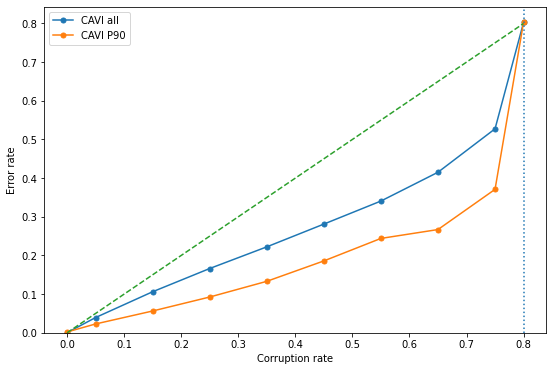

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(deltas2, res2a, marker="o", ms=5, label="CAVI all")
ax.plot(deltas2, res2b, marker="o", ms=5, label="CAVI P90")
ax.plot(deltas2, deltas2, ls="--")
ax.axvline(0.8, ls=":")
ax.set_ylim(bottom=0.0)
ax.set_xlabel("Corruption rate")
ax.set_ylabel("Error rate")
ax.legend()